<a href="https://colab.research.google.com/github/easyhardhoon/machine_learning/blob/master/ML10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#입력인자 (데이터 한개 or 데이터 여러개(batch)) 정리

✈ MNIST 데이터를 예를 들면, 데이터 하나의 크기가 28*28이다. 

데이터 한개가 인자로 들어간다 했을때, 2차원 배열 형식의 28 * 28로 들어가는게 아니고, (784,) 즉 (28*28 , ) 크기의 1차원 배열 형식으로 들어감. 

데이터 여러개가 인자로 들어간다 했을때, (ex 데이터 6만개). 2차원 배열 형식의
(60000,784) 으로 들어간다. 

보통 배치 형태로 들어간다고 가정하고 위 두 조건이 맞도록 코드를 설계하는 편이다

(ex. np.sum(dout, axis=0))

# 3. Softmax-with-Loss 계층

softmax 계층은 보통 맨 마지막 출력층의 활성화함수때 사용. 

입력값을 정규화(출력의 합이 1이 되도록 변형)하여 출력한다. 즉 대소관계는 그대로 유지된다고 볼 수 있다. 

이러한 부분때문에 신경망의 "추론" 작업에서는 softmax 함수가 쓰이지 않는다. 필요가 없기 떄문.

' 그냥 softmax로 인자로 올 예정이던 "score" 인자를 그대로 써버린다. 

반면 신경망의 "학습" 작업에서는 softmax 함수가 중요하다. 

# 모든것은 큰그림이었다

softmax-with-loss (소프트맥스 함수 & 교차 엔트로피 오차) 의 계산 그래프를 보면



Mounted at /gdrive


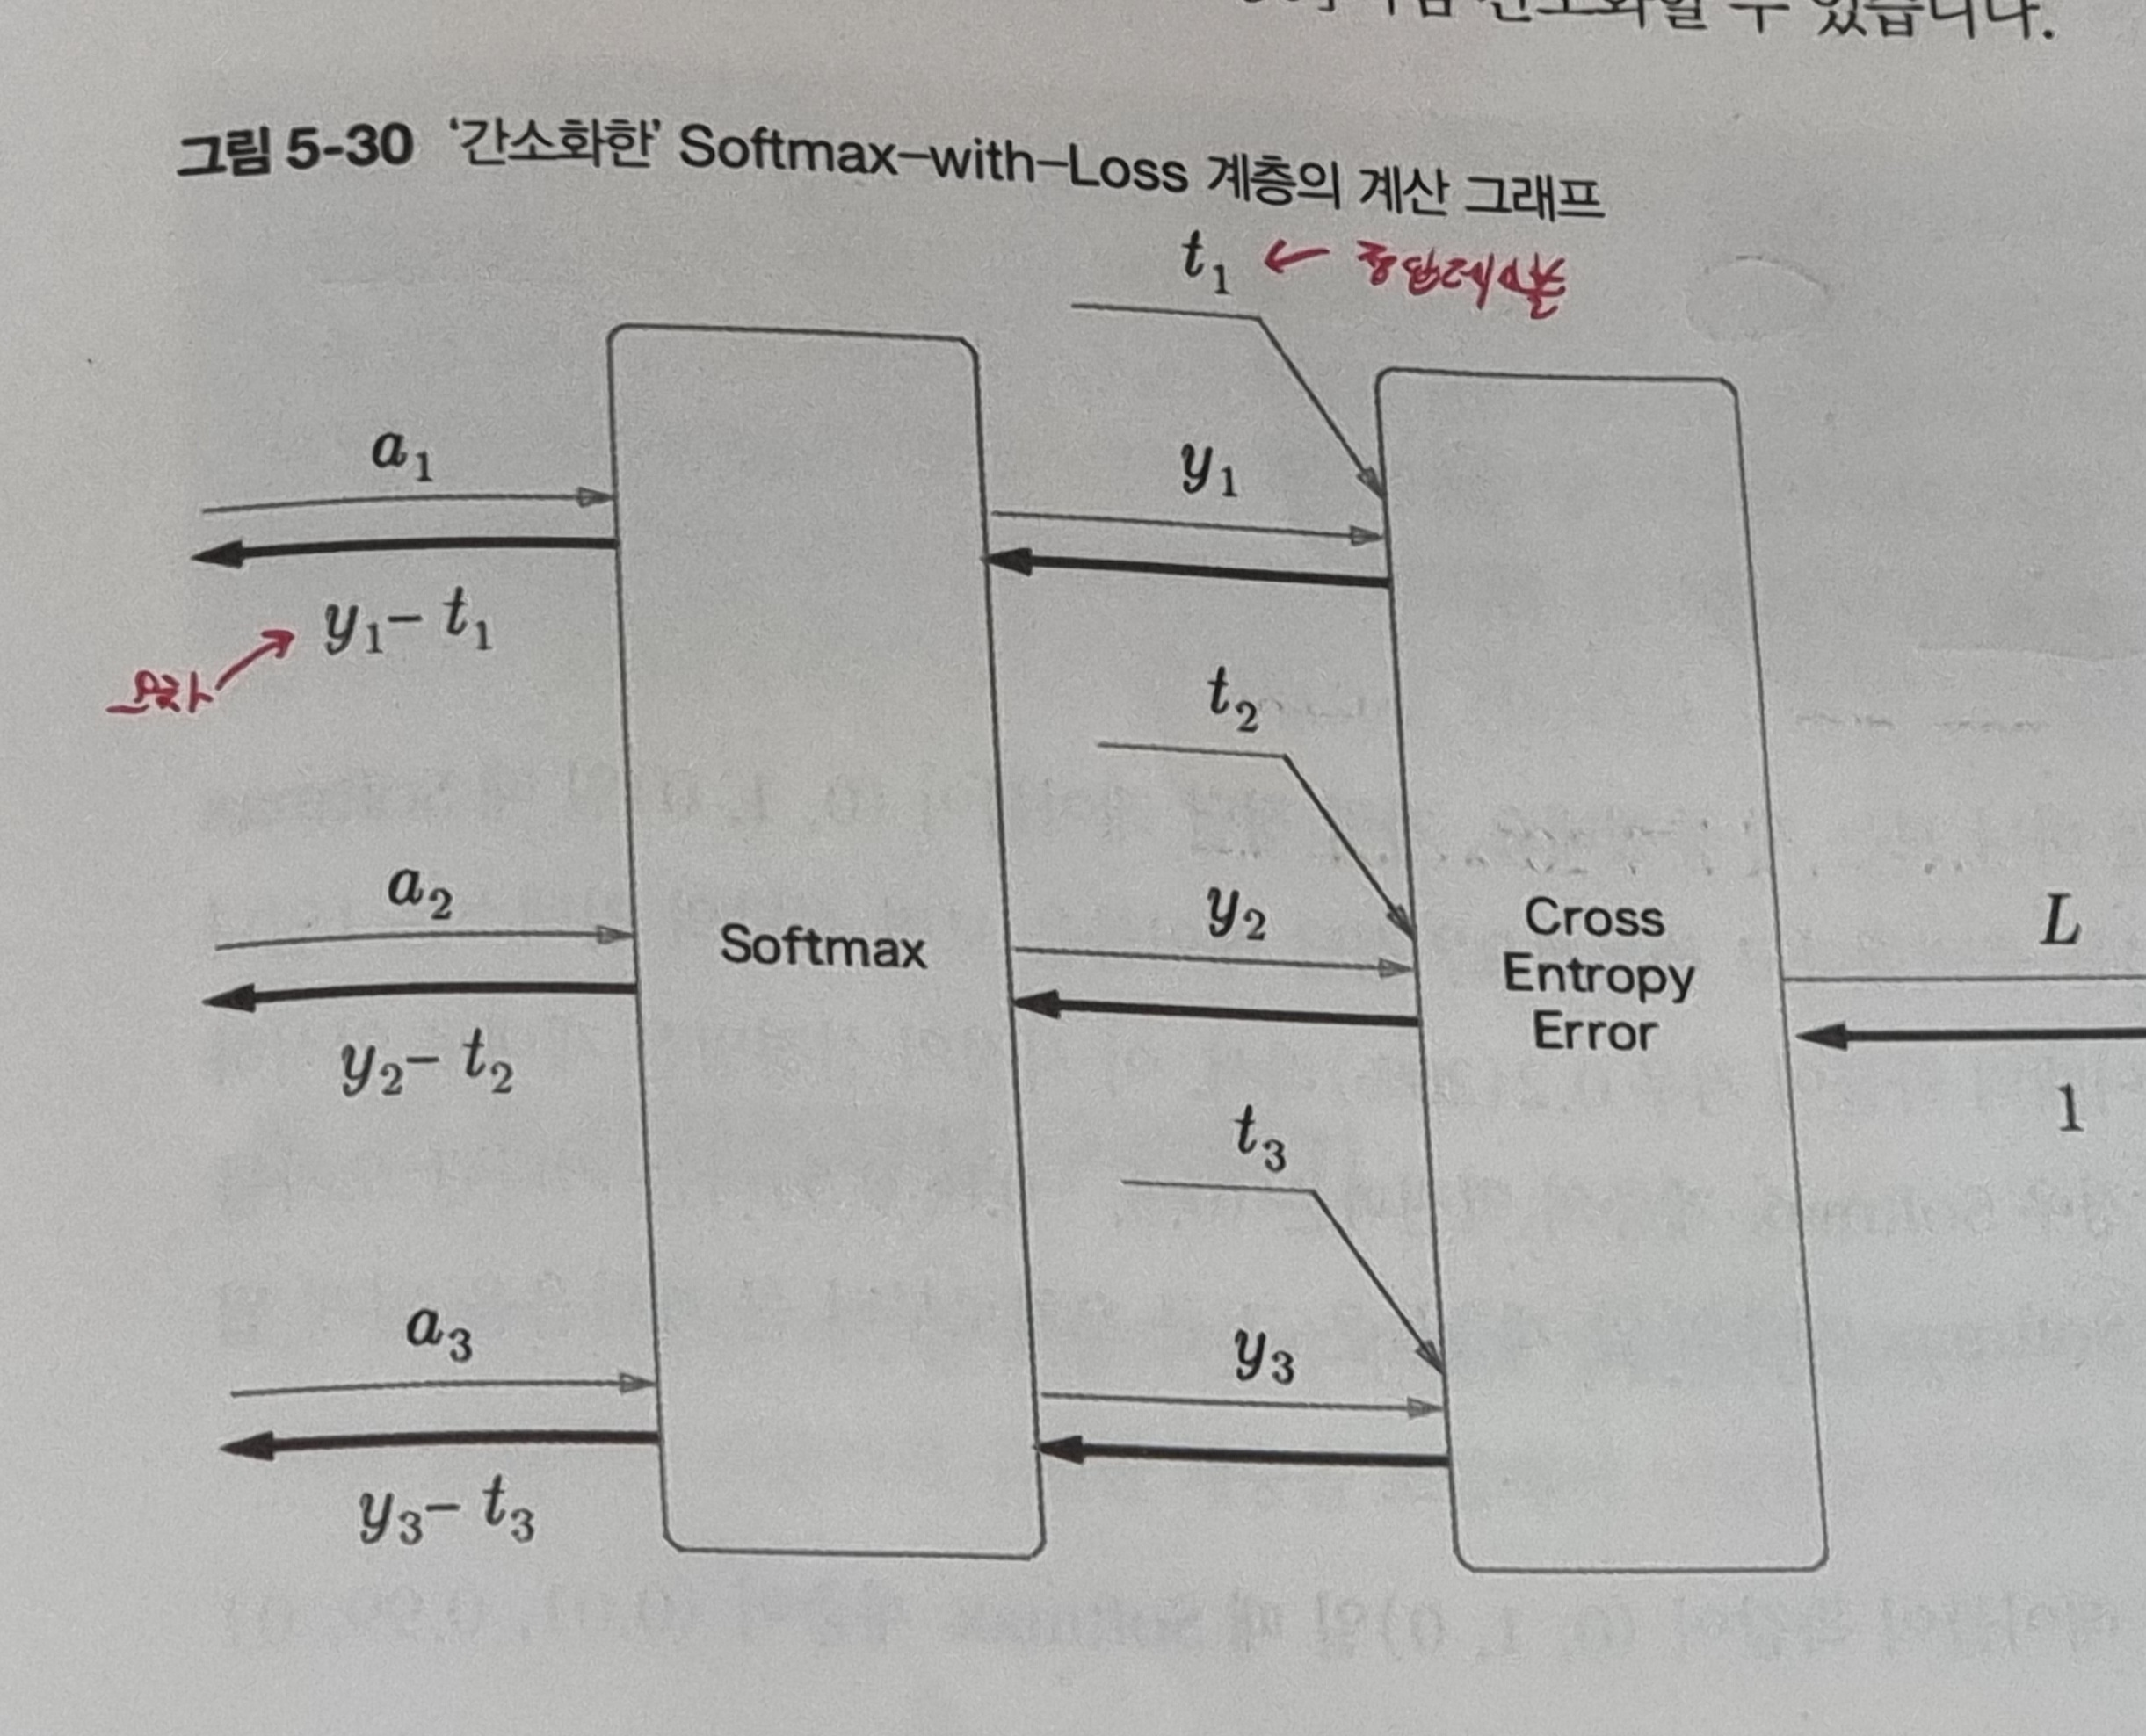

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
from IPython.display import Image
Image('/gdrive/My Drive/test_2.jpg')
#참고용 사진입니다.

#사진에서

1. 3클래스 분류로 가정하고 3개의 입력을 받음. 

2. softmax계층에서 (a1,a2,a3) -> (y1,y2,y3)로 변환

3. cross entropy 계층에서 (y1,y2,y3)와 정답 레이블 (t1,t2,t3)로 손실 L을 출력

#역전파의 관점에서

softmax 계층의 역전파는 (y1-t1, y2-t2, y3-t3)라는 말끔한 결과 가 나옴.

softmax 계층의 출력과 정답 레이블의 차분, 즉 신경망 학습의 목적을 위한 신경망의 현재 출력과 정답 레이블의 "오차"가 앞 계층에 효율적으로 전달됨

###신경망 학습의 목적 : 신경망의 출력(softmax)이 정답 레이블과 가까워지도록 가중치 매개변수의 값을 조정하는 것

이런 말끔함은 우연이 아니라 사실 이렇게 나오도록 교차 엔트로피 함수를 설계한 것.

사실 회귀의 문제에서도 최종 출력층 활성화 함수가 항등함수일떄 손실함수로 오차제곱합을 사용하게 되면 똑같이 "오차"가 앞 계층에 전달됨.

이것이 큰그림이다

#전체 흐름에서 보면

만약 정답 레이블이 (0,1,0) 이고 softmax계층이 (0.3, 0.2, 0.5)를 출력했다면

softmax계층의 역전파는 (0.3, -0.8, 0.5)라는 커다란 오차를 전파.  --> 이는 역전파의 with 교차엔트로피 오차 함수로 인해 얻어진 말끔한 값

결과적으로 softmax계층의 앞 계층들은 그 "큰" 오차로부터 "큰" 깨달음을 얻게 된다

In [33]:
class SoftmaxWIthLoss:
  def __init__(self):
    self.loss = None #손실
    self.y = None #softmax 출력
    self.t = None #정답레이블(원핫인코딩이 되어진)
  def forward(self,x,t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t) #흐름을 보면 당연하다
    return self.loss
  def backward(self,dout=1):
    batch_size = self.t.shape[0] #인풋의 데이터가 몇개인가. 즉 batch의 사이즈가 몇이냐. batch안에 든 데이터가 몇개냐. 다 같은 말이다
    dx = (self.y - self.t)/ batch_size #오차!!!!! 근데 여기에 batch_size를 나누어줘야지. 데이터 한개당!! 10개의 데이터를 한꺼번에 검사하는게 batch의 개념이기 때문이다.
    return dx





#신경망 학습의 전체 그림

**전제 : 신경망에는 적응 가능한 가중치와 편향이 있고**, **이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 "학습"이라고 한다.**

1단계 : 미니배치

훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표이다.

2단계 : 기울기 산출

미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실함수의 값을 가장 작게 하는 방향을 제시한다.

3단계 : 매개변수 갱신

가중치 매개변수를 기울기 방향으로  아주 조금 갱신한다

4단계 : 반복


✈2단계에서, 기울기를 구하기 위한 방법에 주목. 원래는 수치 미분을 사용했으나, 너무 오래 걸렸다. 그래서 오차역전파법을 이용하여 기울기를 효율적이고 빠르게 구해본다


In [38]:
#import하지 않고 그냥 복붙한것입니다.
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

#기본적으로 인자가 batch로 데이터가 전달될때를 모두 고려한 코드입니다.
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

In [50]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
#from layers import *
from gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    #가중치 초기화
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size)
    self.params['b2'] = np.zeros(output_size)

    #계층 생성
    self.layers = OrderedDict() #순서가 있는 딕셔너리. 자료구조임.
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1']) #"affine1"의 value값으로 하나의 클래스가 들어갔음
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    self.lastLayer = SoftmaxWIthLoss() #사실 다 클래스 형태가 value의 위치에 들어간모습
    #신경망의 흐름대로 자연스레 구현한 과정입니다.

  def predict(self,x):
    for layer in self.layers.values():
      x = layer.forward(x) #이러한 층마다의 신경망 기술 구현 가능
    return x
  def loss(self,x,t):
    y = self.predict(x)
    return self.lastLayer.forward(y,t) #맨 마지막 활성화 함수는 sotfmax로 고정한 모습
  def accuracy(self,x,t):
    y = self.predict(x)
    y = np.argmax(y,axis=1)
    #데이터별 최대 값의 인덱스만 끌어모아 배열 하나 생성. 마찬가지로 batch를 위한 코드입니다
    #최대 인덱스만 불러오기 때문에 softmax 함수는 굳이 적용안시킨 모습입니다.
    if t.ndim != 1:
      t = np.argmax(t,axis=1) 
    accuracy = np.sum(y==t)/float(x.shape[0])
    return accuracy

  #항상 x: 입력 데이터, t : 정답 레이블 입니다.
  def numerical_gradient(self,x,t):
    loss_W = lambda W: self.loss(x,t)
    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    #앞서 공부했듯 각각의 가중치 파라미터를 손실함수에 대해 편미분한 값을 일일이 계산해서 저장해놓은 모습입니다.
    #이 방법은 시간이 너무 오래 걸립니다. 그래서 등장한게 역전파의 개념. 즉 아래의 함수입니다.
    return grads

  def gradient(self,x,t):
    self.loss(x,t)
    dout = 1
    dout = self.lastLayer.backward(dout) # "오차"가 기록되어 역전파의 흐름대로 들어갈 준비를 합니다
    layers = list(self.layers.values()) #self의 뜻은. 본연의 라는 뜻입니다.
    layers.reverse() #역전파의 개념이니 뒤집는거임. 역전파의 흐름대로 갈려면 역순으로 가야하는게 당연합니다.

    #ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
    for layer in layers:
      dout = layer.backward(dout) #역전파의 흐름대로 쭉 진행시켜 최종 dout이 나오는 코드입니다.
    grads = {} #바로 위에서 역전파가 쭉 지나갔기 때문에, 각 계층의 dw,db값이 최신화되었습니다.
    grads['W1'] = self.layers['Affine1'].dW # ML9에서 왜 dw,db를 굳이 self로 저장해놓냐 했었는데, 바로 여기서 쓰이기 때문이었다.
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db
    return grads

#위 코드는

신경망의 구성 요소를 **계층**으로 구현함. 

덕분에 신경망을 쉽게 구축 가능. 층이 복잡해져도(ex 10...20...100) 단순히 필요한만큼 계층을 추가하면 끝. 

그럼 수치미분법은 필요가 없는가?

그게 아니고 수치 미분은 오차역전파법을 정확히 구현했는지 확인하기 위해 필요합니다

수치 미분은 구현이 쉽기 떄문에, 수치 미분으로 구한 기울기와 역전파로 구한 기울기가 같은지를 확인하는 작업을 기울기 확인이라고 한다

In [51]:
from mnist import load_mnist
#데이터 읽기
(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size= 784, hidden_size = 50, output_size=10)
#배치크기 설정
x_batch = x_train[:3]
t_batch = t_train[:3]

#두 비교값
grad_numerical = network.numerical_gradient(x_batch, t_batch) #딕셔너리 형태 리턴
grad_backprop = network.gradient(x_batch, t_batch)#딕셔너리 형태 리턴

#각 계층에 대해!
for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key])) #오차의 평균. abs는 절댓값입니다
  print(key + ":" + str(diff))

#결과값을 보면 오차역전법의 기울기가 올바름을 알 수 있다
#사실 0은 나오지 않는다. 컴퓨터의 정밀도가 유한하기 때문. 0에 아주 가까운 값이면 그걸로 충분

W1:2.8585199429277707e-13
b1:1.079578121980485e-12
W2:9.083331781233137e-13
b2:1.1990409498618959e-10


#오차역전파법을 사용한 학습 구현하기

지금까지의 신경망 학습을 코드로 구현합니다.

In [52]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from mnist import load_mnist
#데이터 읽기
(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size= 784, hidden_size = 50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list= []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size,1)

for i in range(iters_num):
  batch_mask = np.random.choice(train_size,batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]
  
  grad = network.gradient(x_batch,t_batch) #오차역전법으로 기울기를 구한다.
  
  for key in ('W1','b1','W2','b2'):
    network.params[key] -= learning_rate * grad[key] #이 구한 것을 각 사이클마다(i) 새로 학습. 작게 최신화.
  loss = network.loss(x_batch, t_batch) #그러고 나서 이번 사이클에서의 loss값 출력. 점점 나아지길 기대!!
  train_loss_list.append(loss)

  if i%iter_per_epoch == 0: #마찬가지로 i가 epoch의 배수일떄만 출력. 다 출력할 필요 x
    train_acc = network.accuracy(x_train,t_train)
    test_acc = network.accuracy(x_test,t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc,test_acc)


0.08631666666666667 0.0895
0.9037666666666667 0.906
0.9205333333333333 0.9236
0.9353 0.9353
0.9409 0.9402
0.9511166666666667 0.9502
0.9550833333333333 0.9538
0.9607166666666667 0.9571
0.9641333333333333 0.9593
0.9673333333333334 0.9623
0.9692833333333334 0.9641
0.9716666666666667 0.9648
0.9732166666666666 0.9661
0.9747833333333333 0.9705
0.9758166666666667 0.9693
0.9774666666666667 0.9715
0.9786666666666667 0.9701


#핵심은...각 계층의 모듈화입니다

ex) 모든 계층(relu, sotfmax_with_loss, affine, softmax ..._)에서 forward, backward 매서드 구현